In [2]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df = pd.read_excel("/content/Online Retail.xlsx")
df.head() # посмотрим на 5 первых строк датасета

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
#изучим общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [11]:
# проверка на наличие пропусков в данных
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [12]:
## В столбцах Description и СustomerID есть пропуски
df= df.dropna(subset=['CustomerID'])
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [13]:
# приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower().str.replace(' ','_')
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [49]:
df['customerid'].nunique()

4338

In [14]:
## проверка на наличие дубликатов в данных
df.duplicated().sum()

5225

In [15]:
len(df)

406829

In [16]:
##удаляем дубликаты
df = df.drop_duplicates()
len(df)

401604

In [17]:
# выводим описательную статистику
df.describe()


,quantity,invoicedate,unitprice,customerid
count,401604.000000,401604,401604.000000,401604.000000
mean,12.183273,2011-07-10 12:08:23.848567552,3.474064,15281.160818
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13939.000000
50%,5.000000,2011-07-29 15:40:00,1.950000,15145.000000
75%,12.000000,2011-10-20 11:58:30,3.750000,16784.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,250.283037,NaN,69.764035,1714.006089


Видим что в столбце quantity минимальное значение имеет знак минуса, также минимальное значение в столбце unitprice = 0

In [18]:
df = df.query('quantity > 0 & unitprice > 0')
len(df)

392692

## Подготовка данных для проведения когортного анализа

Создадим следующие столбцы

Расчетный период - это представление месяца и года отдельной транзакции либо счета,

Когортная группа: представление года и месяца первой покупки клиента,

Продолжительность когорты / лайфтайм: Число представляет собой количество месяцев с момента первой покупки.

In [19]:
# Напишем функцию для определения месяца
def get_month(x):
    return dt.datetime(x.year,x.month,1)

df['invoice_month'] = df['invoicedate'].apply(get_month) ## определяем месяц и год, когды была совершена транзакция

group_by_customerId = df.groupby('customerid')['invoice_month'] ## для каждого уникального покупателя группируем его дату транзакции

df['cohort_month'] = group_by_customerId.transform('min') ## определяем когорту

In [20]:
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,invoice_month,cohort_month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [51]:
# для некоторых столбцов поменяем названия
df = df.rename(columns={'invoiceno':'invoice_no', 'invoicedate':'invoice_date','unitprice':'unit_price'})
df.head()

,invoice_no,stockcode,description,quantity,invoice_date,unit_price,customerid,country,invoice_month,cohort_month,cohort_index
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1


In [22]:
def get_month_int(dframe, column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day

    return year,month,day

In [23]:
invoice_year, invoice_month,_ = get_month_int(df,'invoice_month')
cohort_year, cohort_month,_ = get_month_int(df,'cohort_month')

In [24]:
diff_year = invoice_year - cohort_year

month_diff = invoice_month - cohort_month

df['cohort_index'] = diff_year  * 12 + month_diff + 1

np.random.seed(12)
df.sample()


,invoice_no,stockcode,description,quantity,invoice_date,unit_price,customerid,country,invoice_month,cohort_month,cohort_index
252542,559125,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-07-06 12:32:00,4.15,13985.0,United Kingdom,2011-07-01,2011-03-01,5


In [25]:
#Посчитаем для каждой когорты метрику MAU(количество активной месячной аудитории)
grouping = df.groupby(['cohort_month','cohort_index'])
data_cohort = grouping['customerid'].apply(pd.Series.nunique).reset_index()
data_cohort

,cohort_month,cohort_index,customerid
0,2010-12-01,1,885
1,2010-12-01,2,324
2,2010-12-01,3,286
3,2010-12-01,4,340
4,2010-12-01,5,321
...,...,...,...
86,2011-10-01,2,86
87,2011-10-01,3,41
88,2011-11-01,1,323
89,2011-11-01,2,36


In [26]:
## построим сводную таблицу с помощью pivot_table
cohort_counts = data_cohort.pivot_table(index='cohort_month',columns = 'cohort_index',values='customerid')
cohort_counts

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_month,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Посчитаем метрику retention_rate для каждой когорты
cohort_size = cohort_counts.iloc[:,0]

retention = cohort_counts.divide(cohort_size,axis=0)

retention.round(3) * 100



cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_month,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


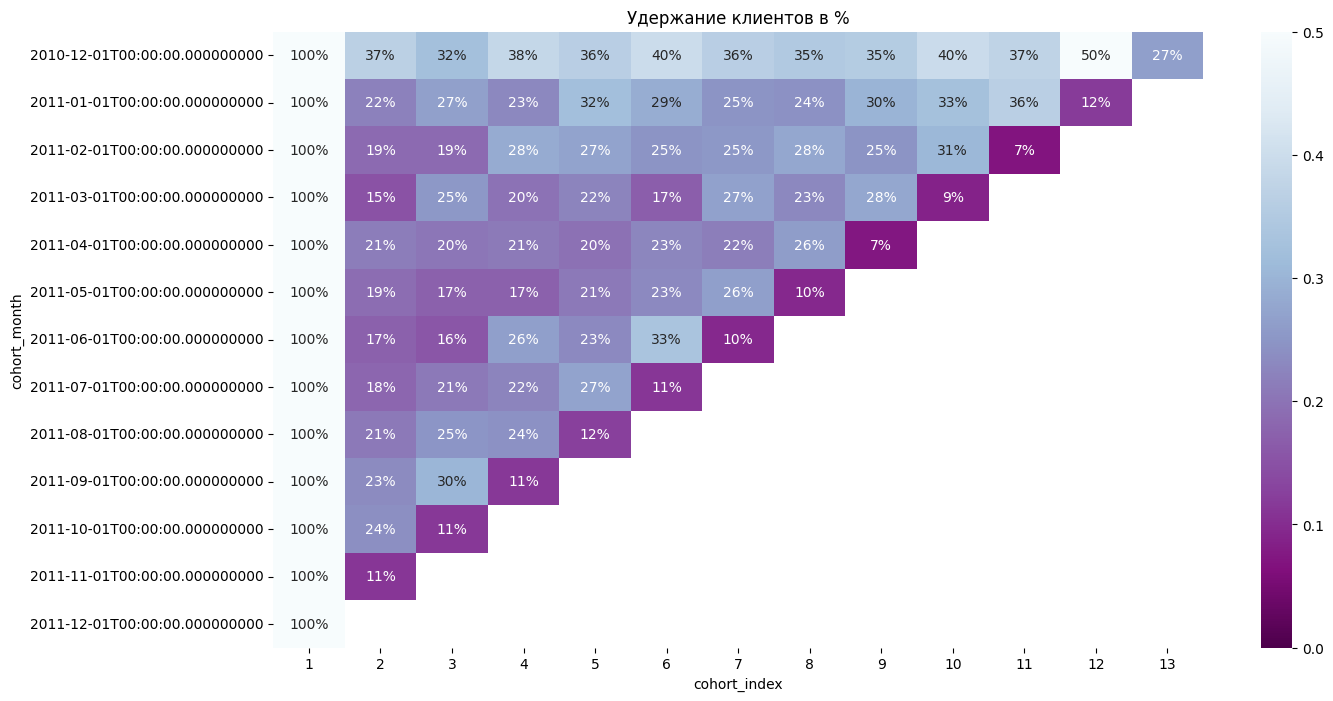

In [33]:
## Построим heatmap
plt.figure(figsize=(15,8))
plt.title('Удержание клиентов в %')
sns.heatmap(data=retention,annot=True,fmt= '.0%', vmin = 0.0, vmax = 0.5, cmap = 'BuPu_r')
plt.show()

Удержание клиентов — очень полезная метрика для понимания того, сколько из всех клиентов проявляют активность.

In [46]:
##Посчитаем среднее количество клиентов для каждой когорты
t = df.groupby(['cohort_month','cohort_index'])
cohort_data = t['quantity'].mean()
cohort_data = cohort_data.reset_index()
## построим сводную таблицу
average_quantity = cohort_data.pivot_table(index='cohort_month',columns='cohort_index',values='quantity').round(1)

average_quantity.index = average_quantity.index.date


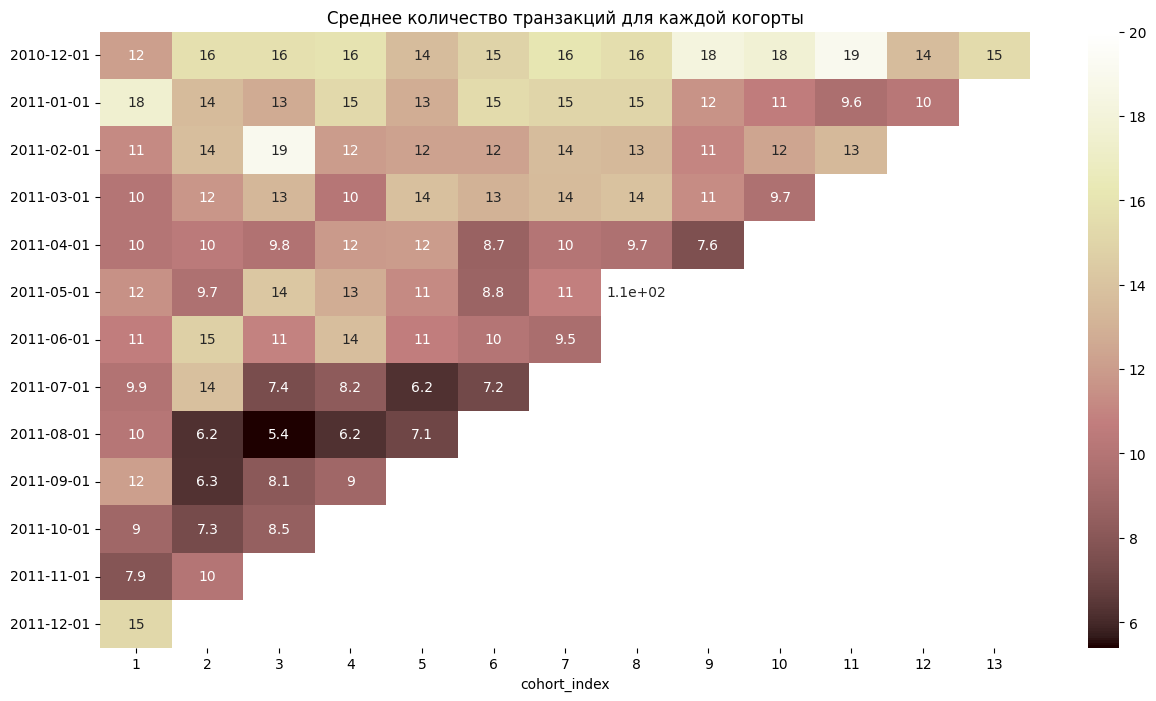

In [50]:
## Построим тепловую карту
plt.figure(figsize=(15,8))
plt.title('Среднее количество транзакций для каждой когорты')
sns.heatmap(data=average_quantity,annot=True,vmax = 20, cmap = 'pink')
plt.show()